### An encoding class for easy look up of the vocabularies.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
#from transformers import CamembertForSequenceClassification as Camembert
from collections import Counter
import itertools
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:


class Vocabulary:
    
    def __init__(self, symbols = None):
        
        #dictionary to map the vocabulary with a id to build matrix
        #add "UNK" for unknown word to the initial mapping  
        self.word2idx = dict()
        self.idx2word = []

        if symbols:
            for sym in symbols:
                self.update(sym)
    @staticmethod
    def read(vocab_file):
        with open(vocab_file, "r", encoding = "utf-8") as f:
            toks = f.read().split(" ")
        return Vocabulary(toks)

    def write(self, filename):
        with open(filename, "w", encoding = "utf-8") as f:
            f.write(" ".join(self.idx2word))

    def update(self, tok):
        
        #takes as input a symbol and build the mapping if it doesnt exist
        if tok not in self.word2idx:
            self.word2idx[tok] = len(self.idx2word)
            self.idx2word.append(tok)

    def lookup(self, tok, update = False):
        
        #find tok id given the string, if the tok does not exist return the idx of "UNK"
        if tok not in self.word2idx:
            if update:
                self.update(tok)
                return self[tok]
            return self.word2idx["<unk>"]
            
        return self.word2idx[tok]
    def rev_lookup(self, idx):
        
        #find the tok string given the id
        return self.idx2word[idx]
    
    def __getitem__(self, symbol):
        
        #if the symbol does not exist we see it as unk
        return self.lookup(symbol)
    
    def __len__(self):
        
        return len(self.idx2word)
    

### Load the data
Conll reader reads the conllu file and Data loader gonna load the data and feed the encoded data to the model(either for training or inference).

In [3]:
"""
Functions for reading and writing UD CONLL data
"""
CONLL_FIELDS = ["token", "pos", "features", "deprel"]
MWE_TAGS     = ["B", "I"]  #B for begin , I for inside


def readfile(filename, update = False, toks_vocab=Vocabulary(["<unk>", "<bos>", "<eos>"]), tags_vocab=Vocabulary(["B_X"])):
    """
    function to read and encode the corpus at one pass 
    signature for train corpus : X_toks, Y_tags = readfile("corpus/train.conllu", update=True)
    signature for test corpus/ dev corpus:  X_test, Y_test = readfile("corpus/train.conllu", update=True, vocabtoks_train, vocabtags_train)
    """

    istream              = open(filename, encoding = "utf-8")
    X_toks, Y_tags       = [], []
    sent_toks, sent_tags = [], []

    for line in istream:
        line = line.strip()
        if line and line[0] != "#":
            try:
                tokidx, token, lemma, upos, pos, features, headidx, deprel, extended, _ = line.split()

            except ValueError:
                pass
            if tokidx == "1":
                #beginning of sentence, add false toks  
                sent_toks.append(toks_vocab["<bos>"])
                sent_tags.append(tags_vocab["B_X"])
            
            #extract simple mwe tags
            mwe_tag = lambda x: "I" if features.startswith("component") else "B"
            #extract tagging information
            sent_toks.append(toks_vocab.lookup(tok = token, update = update))
            sent_tags.append(tags_vocab.lookup(tok = mwe_tag(features) + "_" + upos, update = update))
                
        elif sent_toks:
            #end of sentence, add  false tokens 
            sent_toks.append(toks_vocab["<eos>"])
            sent_tags.append(tags_vocab["B_X"])
            X_toks.append(sent_toks)
            Y_tags.append(sent_tags)
            sent_toks, sent_tags = [], []

    istream.close()
    #return the encoded data in list of list, the nested list represents the sentences
    return X_toks, Y_tags,toks_vocab, tags_vocab
# [{"token1": "token", "multiword": "mwe", "mwe lemma": "mwe lemma"}, {"token2": "token", "multiword": "mwe"}, {"token3": "token", "multiword": "mwe"}]




In [4]:
#build train vocab
X_toks, Y_tags,toks_vocab, tags_vocab = readfile("corpus/train.conllu", update=True)

In [5]:
dist_tags = Counter(itertools.chain(*Y_tags))

[('B_I', 2), ('I_ET', 2), ('I_PONCT', 8), ('I_CL', 21), ('I_PRO', 25), ('I_A', 44), ('I_V', 48), ('B_PREF', 49), ('B_INTJ', 58), ('I_D', 74), ('I_C', 91), ('I_ADV', 105), ('B_ET', 117), ('I_P', 211), ('I_N', 229), ('B_SYM', 329), ('B_PRO', 571), ('B_CL', 969), ('B_C', 1102), ('B_PART', 1198), ('B_SCONJ', 1769), ('B_A', 2170), ('B_V', 3916), ('B_PONCT', 4282), ('B_P', 5435), ('B_D', 5470), ('B_AUX', 5540), ('B_CONJ', 6234), ('B_NUM', 6527), ('B__', 7860), ('B_ADV', 9101), ('B_N', 9750), ('B_PRON', 11141), ('B_ADJ', 14014), ('B_PROPN', 19376), ('B_VERB', 22499), ('B_X', 23540), ('B_PUNCT', 27507), ('B_DET', 38204), ('B_ADP', 39805), ('B_NOUN', 46130)]


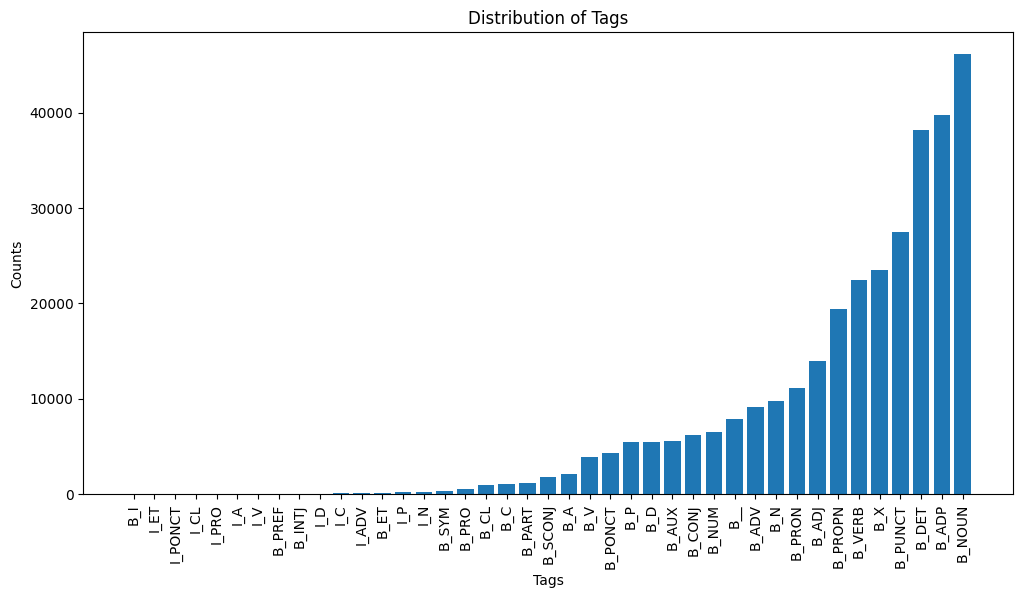

In [6]:
distribution = [(tags_vocab.rev_lookup(tag), freq) for tag, freq in dist_tags.items()]
distribution = sorted(distribution, key = lambda x: x[1])
print(distribution)
tags, counts = zip(*distribution)
plt.figure(figsize=(12, 6))
plt.bar(tags, counts)
plt.xticks(rotation=90)
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.title('Distribution of Tags')
plt.show()

In [7]:
class MWEDataset (Dataset):

    def __init__(self,datafilename = None, toks_vocab=Vocabulary(["<unk>", "<bos>", "<eos>"]), tags_vocab=Vocabulary(["B_X"]), isTrain = False, window_size = 0):
        """
        take as input either the path to a conllu file or a list of tokens
        we consider context size as the n preceding and n subsequent words in the text as the context for predicting the next word.
        """
        super(MWEDataset, self).__init__()

        self.toks_vocab, self.tags_vocab = toks_vocab, tags_vocab
        self.Xtoks_IDs,self.Ytags_IDs, self.toks_vocab, self.tags_vocab = readfile(datafilename,
                                                                                       update=isTrain, 
                                                                                       toks_vocab = toks_vocab, 
                                                                                       tags_vocab=tags_vocab)
                                                                          

     
        print('token Vocab size',len(self.toks_vocab))
        self.window_size  = window_size
        self.data         = self.build_dataset(self.Xtoks_IDs,self.Ytags_IDs)
        self.tags_dist    = Counter(itertools.chain(*self.Ytags_IDs))

        
    def __len__(self):
        return len(self.data)
    
    def build_dataset(self,X_toks,Y_tags):
        """
        build fixed length examples with contextual tokens as features
        takes as input a nested list of encoded corpus, [sentences[tokens]]
        return a list of examples with context window features
        """
        examples = []
        for toks, tags in zip(X_toks, Y_tags):

            toks = [self.toks_vocab["<bos>"]]*self.window_size + toks + [self.toks_vocab["<eos>"]]*self.window_size #3+3+3
            
            for i in range(self.window_size, len(toks)-self.window_size, 1): #3, 6, 1

                examples.append((torch.tensor(toks[i - self.window_size : i + self.window_size+1]), torch.tensor(tags[i - self.window_size])))
                #print(examples[-1])
        return examples
        
    def __getitem__(self, idx):
        
        return self.data[idx]
        
    def as_strings(self,batch_tensor):
        """
        Returns a string representation of a tensor of word indexes
        """
        out = []
        for line in batch_tensor.tolist():
            out.append([self.toks_vocab.rev_lookup(idx) for idx in line])
        return out

    def get_loader(self, batch_size=1, num_workers=0, word_dropout=0., shuffle =False):
        return DataLoader(self, batch_size=batch_size, num_workers=num_workers,shuffle = shuffle)


### Stats

In [8]:
print(len(toks_vocab))
print(len(tags_vocab))

35694
41


In [9]:
corpuspath = "corpus/train.conllu"

train_dataset = MWEDataset("corpus/train.conllu",  isTrain = True,  window_size = 3)
testset    = MWEDataset("corpus/test.conllu", window_size = 3)

token Vocab size 35694
token Vocab size 35694


# Model 模型

In [10]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        # a bahdaunau attention layer to enforce the memory effect
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.Wq = nn.Linear(hidden_size, hidden_size) #query
        self.Wk = nn.Linear(hidden_size, hidden_size)#key
        self.V = nn.Linear(hidden_size, 1) # contextual value

    def forward(self, hidden, logits):
        hidden = hidden.unsqueeze(1)  # (batch_size, 1, hidden_size)
        activate = torch.tanh(self.W1(logits) + self.W2(hidden))  # (batch_size, seq_length, hidden_size)
        attention_weights = F.softmax(self.V(activate), dim=1)  # (batch_size, seq_length, 1)
        new_logits = torch.sum(attention_weights * logits, dim=1)  # (batch_size, hidden_size)
        return new_logits
#why would a  Bahdanau attention layer be beneficial in our sequencial tagging task? 

In [11]:
class MweClassifier(nn.Module):

    def __init__(self, toks_vocab, tags_vocab, window_size=0, emb_size=64, hidden_size=64, pretrainedw2v=None, drop_out=0.):

        super(MweClassifier, self).__init__()

        self.word_embedding = nn.Embedding(len(toks_vocab), emb_size)
        self.window_size = window_size
        self.input_length = 1 + window_size * 2
        self.toks_vocab = toks_vocab
        self.tags_vocab = tags_vocab


        self.net = nn.Sequential(
            nn.Linear(emb_size * self.input_length, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size * 2),
            nn.Dropout(drop_out),
            nn.ReLU(),
            nn.Linear(hidden_size * 2, len(tags_vocab)),  # output # of classes
            nn.LogSoftmax(dim=1)
        )

        if pretrainedw2v:
            pass

    @staticmethod
    def pretrainedw2v_loader(self, path_to_pretrained=None):
        if not path_to_pretrained:
            # Download the pretrained French Word2Vec model https://fauconnier.github.io/#data
            model_name = 'frWac_non_lem_no_postag_no_phrase_500_skip_cut100.bin.gz'
            model = api.load(model_name)
        else:
            model = KeyedVectors.load_word2vec_format(path_to_pretrained, binary=True)
        return model


    def forward(self, Xtoks_IDs):
        b, seq = Xtoks_IDs.shape

        input = self.word_embedding(Xtoks_IDs)  # Batch, inputsize*emb_size
        # print(input.shape) #B, window_size, emb_size
        # input.view(b, -1) B, window_size * emb_size
        return self.net(input.view(b, -1))  # tag_size = 3


    def train_model(self, train_data, test_data, epochs = 10, lr = 1e-3, batch_size = 10, device = "cpu", reg = None, split_train = 0.8):
        """
        the train data is in form of nested lists: [sentences[tokens]]
        """
        self.to(device)
        #adaptive gradient descent, for every update lr is a function of the amount of change in the parameters
        optimizer   = torch.optim.Adam(self.parameters(), lr = lr)
        #optimizer   = torch.optim.SGD(self.parameters(), lr = lr, momentum = 0.9)
        loss_fnc    = nn.NLLLoss()
        test_loader = test_data.get_loader(batch_size=batch_size)

        train_loss = []

        for e in range(epochs):
            self.train()
            #at every epochs we split the traindata into train set and dev set 
            num_train_examples = int(split_train*len(train_data))
            trainset, validset = random_split(train_data, [num_train_examples, len(train_data) - num_train_examples])      
            train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=False)
            dev_loader   = DataLoader(validset, batch_size=batch_size, shuffle=False)

            ep_loss = []
            
            for X_toks, Y_gold in tqdm(train_loader):
                #print(x.shape)
                #print(train_data.as_strings(X_toks))
                #print([self.tags_vocab.rev_lookup(int(y.unsqueeze(dim=0))) for y in Y_gold])
                optimizer.zero_grad()
                logprobs = self.forward(X_toks)
               
                #print(y_hat.shape)
                loss_value = loss_fnc(logprobs, Y_gold)
                ep_loss.append(loss_value.item())
                loss_value.backward()
                optimizer.step()
            loss = sum(ep_loss)/len(ep_loss)
            train_loss.append(loss)
            valid_loss = self.validate(dev_loader)
            
           
            #print("Epoch %d | Mean train loss  %.4f | Mean dev loss %.4f"%(e,loss, devloss) )
            print("Epoch %d | Mean train loss  %.4f |  Mean dev loss  %.4f "%(e,loss, valid_loss) )
            print()
        
        average_precision, average_recall,average_f1_score, weighted_f1_score, weighted_recall,weighted_precision  = self.evaluate(test_loader)
        print("Avr Precision %.4f | Avr Recall  %.4f |  Avr F-score  %.4f "%(average_precision, average_recall, average_f1_score) )
        print("Wighted Precision %.4f |Wighted Recall  %.4f |Wighted  F-score  %.4f "%(weighted_precision, weighted_recall, weighted_f1_score) )


    def validate(self, data_loader, device = "cpu"):
        loss_fnc   = nn.NLLLoss()
        loss_lst   = []
        self.eval()
        with torch.no_grad():
            for X_toks, Y_gold in tqdm(data_loader):
                logprobs = self.forward(X_toks)
               
                loss = loss_fnc(logprobs, Y_gold)
                loss_lst.append(loss)
        return sum(loss_lst)/len(loss_lst)
                
            
    def predict(self, string):
        """
        
        """
        self.eval()
        

        pass
    def evaluate(self, test_loader):
        """
        evaluation the classifier with confusion matrix : precision recall and f-score
        """
        self.eval()
        num_tags = len(self.tags_vocab)
        #print(num_tags)
        TP   = torch.zeros(num_tags)
        FP   = torch.zeros(num_tags)
        FN   = torch.zeros(num_tags)
        class_counts = torch.zeros(num_tags)
        with torch.no_grad():
            for X_toks, Y_golds in tqdm(test_loader):
                logprobs              = self.forward(X_toks)
                scores, predicted_IDs = torch.max(logprobs.data, dim = 1)
                #convert tensor to np arrays
                predicted_IDs = predicted_IDs.cpu().numpy()
                Y_golds    = Y_golds.cpu().numpy()
                for tag in range(num_tags):
                    TP[tag] +=  ((predicted_IDs == tag) & (Y_golds == tag)).sum()
                    FP[tag] += ((predicted_IDs == tag) & (Y_golds != tag)).sum()
                    FN[tag] += ((predicted_IDs != tag) & (Y_golds == tag)).sum()
                    class_counts[tag] += (Y_golds == tag).sum()
        # Calculate precision, recall, and F1 score for each tag
        precision = TP / (TP + FP)
        #avoid nan
        nan_mask = torch.isnan(precision)
        precision[nan_mask] = 0.
        
        recall = TP / (TP + FN)
        #avoid nan
        nan_mask = torch.isnan(recall)
        recall[nan_mask] = 0.
        
        f1_score = 2 * (precision * recall) / (precision + recall)
        #avoid nan
        nan_mask = torch.isnan(f1_score)
        f1_score[nan_mask] = 0.
        # Calculate class weights
        class_weights = class_counts / class_counts.sum()
        
       # Calculate average precision, recall, and F1 score
        average_precision = torch.mean(precision)
        average_recall = torch.mean(recall)
        average_f1_score = torch.mean(f1_score)
    
        weighted_f1_score = torch.sum(f1_score * class_weights)
        weighted_recall   = torch.sum(recall * class_weights)
        weighted_precision= torch.sum(precision * class_weights)

        return average_precision, average_recall,average_f1_score, weighted_f1_score, weighted_recall,weighted_precision
        
    @staticmethod
    def load(modelfile,toks_vocab, tags_vocab, window_size , embsize, hidden_size , device = "cpu"):
        vocab_toks = Vocabulary.read(toks_vocab)
        vocab_tags = Vocabulary.read(tags_vocab)
        model      = MweClassifier(vocab_toks, vocab_tags, window_size , embsize, hidden_size, device)
        model.load_params(modelfile,device)
        return model,vocab_toks, vocab_tags

    def load_params(self,param_filename,device):
        self.load_state_dict(torch.load(param_filename, map_location=device))

    def save(self, path):
        self.toks_vocab.write("toks.vocab")
        self.toks_vocab.write("toks.vocab")
        torch.save(self.state_dict(), path)

In [12]:
#define the hyperparameters
batch_size    = 32
window_size   =  3#left context and right context
lr            = 1e-3
device        = "cpu"
epochs        = 50
emb_size      = 64
hidden_size   = 64
nb_layers     = 2
drop_out      = 0.

In [13]:
train_dataset = MWEDataset("corpus/train.conllu",  isTrain = True,  window_size = 3)
testset    = MWEDataset("corpus/test.conllu", window_size = 3)
#train_dataset.toks_vocab.write("toks.vocab")
#train_dataset.tags_vocab.write("tags.vocab")


token Vocab size 35694
token Vocab size 35694


In [14]:
model = MweClassifier(toks_vocab   = train_dataset.toks_vocab,
                     tags_vocab   = testset.tags_vocab, 
                     window_size  = 3, 
                     emb_size     = emb_size, 
                     hidden_size  = hidden_size, 
                     drop_out     = 0.2)

In [ ]:
model.train_model(train_dataset,testset, epochs= 6, lr=1e-2, batch_size = batch_size, split_train=0.8)

100%|█████████████████████████████████████| 1973/1973 [00:00<00:00, 3488.96it/s]


Epoch 0 | Mean train loss  0.9980 |  Mean dev loss  0.7895 



100%|█████████████████████████████████████| 1973/1973 [00:00<00:00, 2615.16it/s]


Epoch 1 | Mean train loss  0.8187 |  Mean dev loss  0.7601 



 73%|████████████████████████████▎          | 5729/7889 [01:29<00:33, 64.57it/s]

### Scripts to save the trained model

In [19]:
model.save("model.pth")

### Scripts to load the trained model from model file

In [188]:
model, vocab_toks, vocab_tags = MweClassifier.load("model.pth", "toks.txt", "tags.txt", window_size = 3, embsize=64, hidden_size = 64, device = "cpu")

In [189]:
testset    = MWEDataset("corpus/test.conllu", toks_vocab = vocab_toks, tags_vocab = vocab_tags, window_size = 3)

token Vocab size 35694


In [190]:
average_precision, average_recall,average_f1_score, weighted_f1_score, weighted_recall,weighted_precision  = model.evaluate(testset.get_loader(batch_size=500))

100%|████████████████████████████████████████| 632/632 [00:03<00:00, 175.76it/s]


In [191]:
print(average_precision)
print(average_recall)
print(average_f1_score)
print(weighted_f1_score)
print(weighted_recall)
print(weighted_precision)

tensor(0.5152)
tensor(0.3725)
tensor(0.3781)
tensor(0.7594)
tensor(0.7937)
tensor(0.7812)


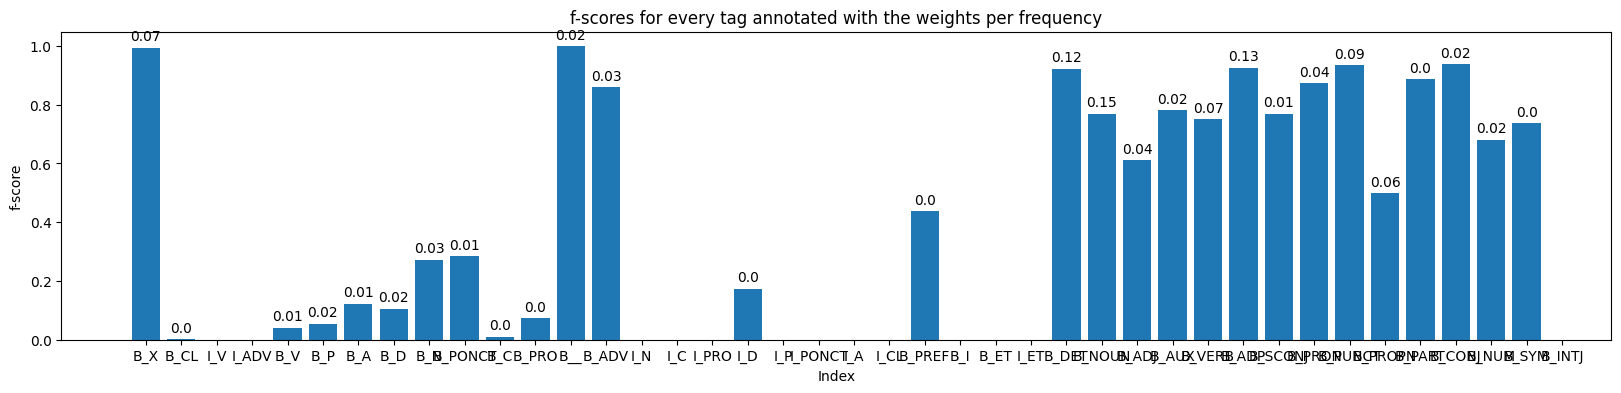

In [125]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 4))

bars = ax.bar([tags_vocab.rev_lookup(i) for i in range(len(tags_vocab))], f1_score)

for i, bar in enumerate(bars):
    weights = class_weight[i]
    ax.annotate(str(round(float(class_weight[i]), 2)), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')

# Set labels and title
ax.set_xlabel('Index')
ax.set_ylabel('f-score')
ax.set_title('f-scores for every tag annotated with the weights per frequency')

# Show the plot
plt.show()